In [15]:
import pandas as pd
import networkx as nx
from datetime import datetime
from typing import List, Dict, Any, Tuple
import numpy as np

In [16]:
entities_df = pd.read_parquet('../data/jp_morgan/sorted/entities_final_fraud.parquet')
transactions_df =  pd.read_parquet('../data/jp_morgan/sorted/nodes_final_fraud.parquet')

In [17]:
# Implement a graph network using networkx in python.
# # Requirements:

# NODES:
# 1. Entity Types:
#    - Regular Entities (with account/country info)
#    - Standalone Entities (ID only, typically counterparties)
#    - CASH node (special node for cash transactions)

# 2. Account Nodes:
#    - Connected to their parent entities
#    - Some entities have multiple accounts
#    - Some entities have no accounts

# 3. Node Properties:
#    ```
#    Entity Node:
#    - entity_id (from party_Id/cparty_Id)
#    - node_type: 'ENTITY' or 'STANDALONE'
#    - country

#    Account Node:
#    - node_id: {entity_id}_{account}
#    - entity_id (parent)
#    - account number
#    - node_type: 'ACCOUNT'

#    Cash Node:
#    - node_id: 'CASH'
#    - node_type: 'CASH'
#    ```

# 4. Entity-Account Relationships:
#    - Entity → Account (HAS_ACCOUNT)
#    - Not all entities have accounts

# Input would be a dataframe containing all unique combinations of id, account, country (may be incomplete)
# Take into consideration that edges will be added for transactions.
# Include sample code on how do add future nodes and how to add transaction edges?
# Can we implement this in networkx and I want to be able to handle batch adding
# The entities/accounts are in a dataframe that I can load, columns are the following (Id, Account, Country)
# Add the code after this and if possible vectorised adding because I have 250k rows

import networkx as nx
import pandas as pd
from typing import Optional

class TransactionGraph:
    def __init__(self):
        self.G = nx.MultiDiGraph()
        # Create CASH node
        self.G.add_node('CASH', node_type='CASH')
        
    def add_entity_node(self, entity_id: str, country: Optional[str] = None):
        """Add an entity node with optional country info"""
        node_type = 'ENTITY' if country else 'STANDALONE'
        attrs = {'node_type': node_type}
        if country:
            attrs['country'] = country
        self.G.add_node(entity_id, **attrs)
        
    def add_account_node(self, entity_id: str, account: str):
        """Add an account node and link it to its parent entity"""
        account_id = f"{entity_id}_{account}"
        self.G.add_node(account_id, 
                       node_type='ACCOUNT',
                       entity_id=entity_id,
                       account_number=account)
        self.G.add_edge(entity_id, account_id, relationship='HAS_ACCOUNT')
        
    def batch_create_nodes(self, df: pd.DataFrame):
        """Batch create nodes from a dataframe with Id, Account, Country columns"""
        # First create all entity nodes
        entities = df[['Id', 'Country']].drop_duplicates()
        for _, row in entities.iterrows():
            self.add_entity_node(str(row['Id']), row['Country'])
            
        # Then create account nodes where they exist
        accounts = df[df['Account'].notna()][['Id', 'Account']]
        for _, row in accounts.iterrows():
            self.add_account_node(str(row['Id']), str(row['Account']))


    def add_transaction_edge(self, party_id: str, counterparty_id: str,
                           transaction_id: str, amount: float,
                           txn_time_hr: int, txn_time_mm: int, txn_age_days: int,
                           is_credit: bool, std_txn_type: str):
        """Add a transaction edge between nodes with relative time and direction based on credit flag
        
        Args:
            party_id: ID of the party node
            counterparty_id: ID of the counterparty node 
            transaction_id: Unique transaction identifier
            amount: Transaction amount
            txn_time_hr: Hour of transaction (0-23)
            txn_time_mm: Minute of transaction (0-59) 
            txn_age_days: Days since transaction
            is_credit: True if money flows into party account, False if flows out
            std_txn_type: Standardized transaction type
        """
        # For deposits/withdrawals, use CASH node
        if std_txn_type in ['DEPOSIT', 'WITHDRAWAL']:
            if std_txn_type == 'DEPOSIT':
                from_id = 'CASH'
                to_id = party_id
            else:  # WITHDRAWAL
                from_id = party_id
                to_id = 'CASH'
        else:
            # For other transactions, direction based on is_credit
            if is_credit:
                from_id = counterparty_id
                to_id = party_id
            else:
                from_id = party_id
                to_id = counterparty_id
                
        self.G.add_edge(from_id, to_id,
                       transaction_id=transaction_id,
                       amount=amount,
                       txn_time_hr=txn_time_hr,
                       txn_time_mm=txn_time_mm, 
                       txn_age_days=txn_age_days,
                       relationship='TRANSACTION',
                       std_txn_type=std_txn_type)

    def batch_add_transaction_edges(self, df: pd.DataFrame):
        """Batch add transaction edges from a dataframe
        
        Args:
            df: DataFrame with columns:
                - party_id: ID of the party node
                - counterparty_id: ID of the counterparty node
                - transaction_id: Unique transaction identifier 
                - amount: Transaction amount
                - txn_time_hr: Hour of transaction (0-23)
                - txn_time_mm: Minute of transaction (0-59)
                - txn_age_days: Age of entity on transaction
                - is_credit: True if money flows into party account
                - std_txn_type: Standardised transaction type
        """
        # Vectorized processing of from_id and to_id based on transaction type
        df['from_id'] = df.apply(lambda x: 
            'CASH' if x['std_txn_type'] == 'DEPOSIT' else
            x['party_id'] if x['std_txn_type'] == 'WITHDRAWAL' else
            x['counterparty_id'] if x['is_credit'] else x['party_id'], axis=1)
            
        df['to_id'] = df.apply(lambda x:
            x['party_id'] if x['std_txn_type'] == 'DEPOSIT' else
            'CASH' if x['std_txn_type'] == 'WITHDRAWAL' else
            x['party_id'] if x['is_credit'] else x['counterparty_id'], axis=1)

        # Batch add edges
        edges = [(row['from_id'], row['to_id'], {
            'transaction_id': row['transaction_id'],
            'amount': row['amount'],
            'txn_time_hr': row['txn_time_hr'],
            'txn_time_mm': row['txn_time_mm'],
            'txn_age_days': row['txn_age_days'],
            'relationship': 'TRANSACTION',
            'std_txn_type': row['std_txn_type']
        }) for _, row in df.iterrows()]
        
        self.G.add_edges_from(edges)
        
    
    # def add_transaction_edge(self, from_id: str, to_id: str, 
    #                        transaction_id: str, amount: float, 
    #                        timestamp: str):
    #     """Add a transaction edge between nodes"""
    #     self.G.add_edge(from_id, to_id,
    #                    transaction_id=transaction_id,
    #                    amount=amount,
    #                    timestamp=timestamp,
    #                    relationship='TRANSACTION')

# Example usage:
# graph = TransactionGraph()
# df = pd.DataFrame({
#     'Id': ['E1', 'E2', 'E3'],
#     'Account': ['A1', 'A2', None],
#     'Country': ['US', 'UK', None]
# })
# graph.batch_create_nodes(df)
# 
# # Add a transaction
# graph.add_transaction_edge('E1_A1', 'E2_A2', 'T1', 1000.0, '2023-01-01')


In [18]:
graph = TransactionGraph()

In [19]:
graph.batch_create_nodes(entities_df)

In [20]:
graph.batch_add_transaction_edges(transactions_df)

In [21]:
graph.G.size()

1803887

In [22]:
import pickle

with open('../data/jp_morgan/pickled/graph_fraud_final.pickle', 'wb') as f:
    pickle.dump(graph.G, f)

KeyboardInterrupt: 

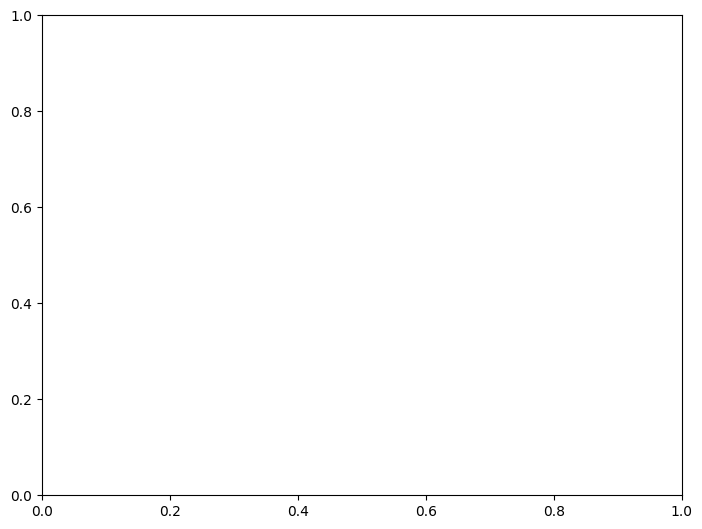

In [7]:
nx.draw(graph.G)

In [17]:
from pyvis.network import Network

nx_graph = graph.G
nt = Network('1000px', '1000px')
nt.from_nx(nx_graph)
nt.save_graph('nx.html', )

EdgeView([('JPMC-CLIENT-1834121-00', 'JPMC-CLIENT-1834121-00_CHECKING-1834129-00'), ('JPMC-CLIENT-239570-10', 'JPMC-CLIENT-239570-10_CHECKING-239582-10'), ('JPMC-CLIENT-1504507-00', 'JPMC-CLIENT-1504507-00_CHECKING-1504515-00'), ('JPMC-CLIENT-1009557-10', 'JPMC-CLIENT-1009557-10_CHECKING-1009564-10'), ('JPMC-CLIENT-704246-10', 'JPMC-CLIENT-704246-10_CHECKING-704257-10'), ('JPMC-CLIENT-380491-04', 'JPMC-CLIENT-380491-04_CHECKING-380499-04'), ('JPMC-CLIENT-380491-04', 'JPMC-CLIENT-380491-04_CHECKING-380503-04'), ('JPMC-CLIENT-113338-06', 'JPMC-CLIENT-113338-06_CHECKING-113351-06'), ('JPMC-CLIENT-804185-04', 'JPMC-CLIENT-804185-04_CHECKING-804195-04'), ('JPMC-CLIENT-23746-05', 'JPMC-CLIENT-23746-05_CHECKING-23754-05'), ('JPMC-CLIENT-346764-04', 'JPMC-CLIENT-346764-04_CHECKING-346772-04'), ('JPMC-CLIENT-1166443-00', 'JPMC-CLIENT-1166443-00_CHECKING-1166450-00'), ('JPMC-CLIENT-466716-11', 'JPMC-CLIENT-466716-11_CHECKING-466726-11'), ('JPMC-CLIENT-1464549-10', 'JPMC-CLIENT-1464549-10_CHECKIN

In [25]:
graph.G.edges.data()

EdgeDataView([('JPMC-CLIENT-1834121-00', 'JPMC-CLIENT-1834121-00_CHECKING-1834129-00', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-239570-10', 'JPMC-CLIENT-239570-10_CHECKING-239582-10', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-1504507-00', 'JPMC-CLIENT-1504507-00_CHECKING-1504515-00', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-1009557-10', 'JPMC-CLIENT-1009557-10_CHECKING-1009564-10', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-704246-10', 'JPMC-CLIENT-704246-10_CHECKING-704257-10', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-380491-04', 'JPMC-CLIENT-380491-04_CHECKING-380499-04', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-380491-04', 'JPMC-CLIENT-380491-04_CHECKING-380503-04', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-113338-06', 'JPMC-CLIENT-113338-06_CHECKING-113351-06', {'relationship': 'HAS_ACCOUNT', 'width': 1}), ('JPMC-CLIENT-804185-04', 'JPMC-CLIENT-804185-04_

In [8]:
graph.G.is_multigraph()

True